In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import csv

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [ ]:
def loadTrainData(path='../data/train.csv'):
    df = pd.read_csv(path)
    df["Soil_Type_1"] = df["Soil_Type"] // 1000
    df["Soil_Type_2"] = df["Soil_Type"] % 1000 // 100
    df["Soil_Type_3"] = df["Soil_Type"] % 100 // 10
    df["Soil_Type_4"] = df["Soil_Type"] % 10
    print(f"Loaded {os.path.basename(path)}. Shape: {df.shape}")
    return df.drop(['From_Cache_la_Poudre','ID','Soil_Type'], axis=1), df['From_Cache_la_Poudre']

def loadTestData(path='../data/test.csv'):
    df = pd.read_csv(path)
    df["Soil_Type_1"] = df["Soil_Type"] // 1000
    df["Soil_Type_2"] = df["Soil_Type"] % 1000 // 100
    df["Soil_Type_3"] = df["Soil_Type"] % 100 // 10
    df["Soil_Type_4"] = df["Soil_Type"] % 10
    print(f"Loaded {os.path.basename(path)}. Shape: {df.shape}")
    return df.drop(['ID','Soil_Type'],axis=1), df["ID"]

def l2distance(x, y):
    m = x.shape[0] # x has shape (m, d)
    n = y.shape[0] # y has shape (n, d)
    x2 = np.sum(x**2, axis=1).reshape((m, 1))
    y2 = np.sum(y**2, axis=1).reshape((1, n))
    xy = x.dot(y.T) # shape is (m, n)
    dists = x2 + y2 - 2*xy # shape is (m, n)
    return dists

def write_submission(testID, preds):
    f = 'submission.csv'
    with open(f, 'w') as csvfile:
        csvwriter = csv.writer(csvfile, delimiter=',')
        row = ['ID', 'From_Cache_la_Poudre']
        csvwriter.writerow(row)
        for ID, pred in zip(testID, preds):
            csvwriter.writerow([ID, pred])

In [1]:
# Load data
X, y = loadTrainData()
print(X.columns)
X, y = X.values, y.values
print(X.shape)

NameError: name 'loadTrainData' is not defined

In [4]:
# Data preprocessing
# X, labels = X[:2000, :], y[:2000]
y = y.reshape(-1, 1)

# Basic feature engineering
X[:, 1] = np.sin(X[:, 1] * np.pi / 180)

# Data scaling
means = np.mean(X, axis=0)
stds = np.std(X, axis=0)
X = (X - means) / stds

In [5]:
# Covariance parameters
gamma = 0.1
alpha = 10
N = len(y)

In [6]:
# Compute covariance for training data.
C = alpha * np.exp(-gamma * l2distance(X, X))

In [7]:
# Invert C now for performance.
f = np.zeros((N, 1))
invC = np.linalg.inv(C) # This takes a while.

In [8]:
# Newton-Raphson procedure for finding MAP f. (This takes a really long time.)
max_its = 10
allf = np.zeros((max_its, N))
allf[0, :] = f.T
for it in range(max_its - 1):
    g = np.divide(1, (1 + np.exp(-f)))
    gradient = np.dot(-invC, f) + y - g
    hessian = -invC - np.diagflat(g * (1-g))
    f -= np.dot(np.linalg.pinv(hessian), gradient)
    allf[it+1, :] = f.T
hessian = -invC - np.diag(g * (1-g))

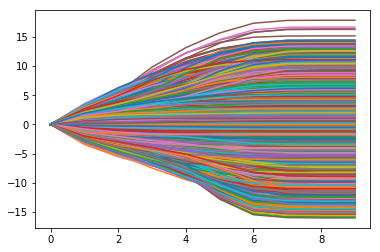

In [9]:
a = plt.plot(allf)

In [10]:
# Load test set.
Xte, IDs = loadTestData()
Xte = Xte.values

# Basic feature engineering
Xte[:, 1] = np.sin(Xte[:, 1] * np.pi / 180)

# Use stored means and stds for data scaling.
Xte = (Xte - means) / stds

Loaded test.csv. Shape: (21453, 16)


In [11]:
# Covariance functions
R = alpha * np.exp(-gamma * l2distance(X, Xte)**2)
# Cstar = alpha * np.exp(-gamma * l2distance(testx, testx)**2)

# Latent function
fs = np.dot(np.dot(R.T, invC), f)

# Probabilistic predictions
preds = 1 / (1 + np.exp(-fs))
preds = np.concatenate(preds, axis=0)

In [14]:
# Output
write_submission(IDs, preds)

1.8413262747550277e-27